<h1><center>Identificação de sistemas de segunda ordem utilizando redes neurais da bliblioteca pytorch</center></h1>

By: Nei Junior da Silva Farias

# Importação das bicliotecas utilizadas

In [1]:
import torch                         # Biblioteca de redes neurais utilizada
from torch import nn, optim                # Importação do componente de geração, treinamento e teste da rede
import numpy as np
from numpy.random import normal      # Import do gerador de sinal aleatório
from scipy.integrate import odeint   # Import do integrador utilizado para simular o sistema identificado
import matplotlib.pyplot as plt      # Import da biblioteca para plot de gráficos
from torch.utils.data import Dataset, DataLoader

# Representação de sistemas de segunda Ordem

Os sistemas de segunda ordem pode ser representados pela função de transferência:

<h2><center>
    $G(s)=\frac{y(t)}{u(t)} = \frac{\omega_0}{s^2+2\zeta\omega s + \omega_0^2}$
</h2></center>

A representação diferencial da função de transferência pode ser dada por:

<h2><center>
    $\frac{d^2y(t)}{dt^2} + 2\zeta\omega \frac{dy(t)}{dt} +\omega_0^2y(t) = \omega_0^2u(t)$
</h2></center>

A escolhermos as variáveis de estados $x_1 = y(t)$ e $x_2 = \frac{dy(t)}{dt}$ o sistema pode ser reescrito como:

<h2><center>
    $\begin{matrix}
    \dot{x}_1 = x_2 \\
    \dot{x}_2= - 2\zeta\omega x_2 - \omega_0^2x_1 + \omega_0^2u(t)
    \end{matrix}$
</h2></center>

Onde:

<h2><center>
    $\begin{matrix}
    y(t) = x_1(t)
    \end{matrix}$
</h2></center>

## Definição do modelo em python

In [2]:
def model(z,t_estp,u,zeta,w0):
    x1 = z[0]
    x2 = z[1]
    dx1dt = x2
    dx2dt = -(2*zeta)*x2-(w0**2)*x1 + w0**2*u
    dzdt = [dx1dt,dx2dt]
    return dzdt

## Obteção da entrada aleatória de média nula

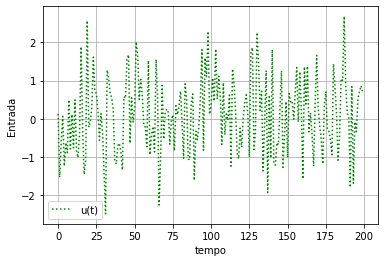

In [3]:
media = 0;
desvio_padrao = 1;
tamanho = 200;
SEED = 16;
np.random.seed(SEED);
u = normal(media,desvio_padrao, tamanho)
plt.plot(u,'g:',label='u(t)')
plt.ylabel('Entrada')
plt.xlabel('tempo')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Integral do sistema para a entrada

### Tempo da simulação

In [4]:
numero_de_pontos = 5000 # Número de pontos
tempo_inicial = 0;
tempo_final   = 400;
t = np.linspace(tempo_inicial,tempo_final, numero_de_pontos)

### Variáveis de armazenamento de dados

In [5]:
X1t = np.empty_like(t)
X2t = np.empty_like(t)
Ut = np.empty_like(t)

### Definição dos parâmetros do sistema

In [6]:
tempo_de_acomodacao = 3; # tempo em segundos
maximo_sobressinal = 10; # Em porcentos

### Obteção do coeficiente de amortecimento e frequência de oscilação

In [7]:
zeta = (-np.log(maximo_sobressinal/100))/(np.sqrt((np.pi)**2+np.log(maximo_sobressinal/100)**2))
w0 = 3/(zeta*tempo_de_acomodacao)

### Teste da resposta ao degrau do sistema de segunda ordem

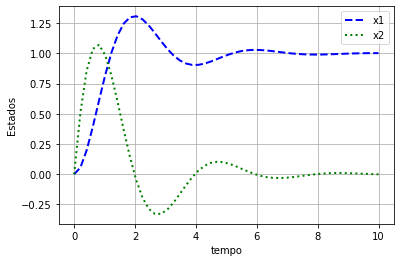

In [19]:
tprint =  np.linspace(0,10,50)
z0 = [0,0] # Condição inicial
degrau = 1;
z = odeint(model,z0,tprint,args = (degrau,zeta,w0,))
x1 = z[:,0]
x2 = z[:,1]
plt.plot(tprint,x1,'b--',linewidth=2,label='x1')
plt.plot(tprint,x2,'g:',linewidth=2,label='x2')
plt.xlabel('tempo')
plt.ylabel('Estados')
plt.legend()
plt.grid(True)
plt.show()

### Obtenção do conjunto de treino da rede

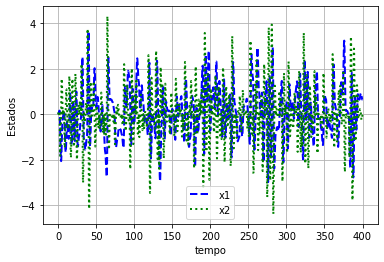

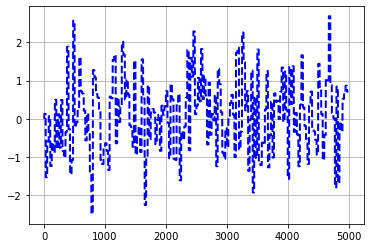

In [9]:
j = 1;
z0 =[0,0]
entrada = u[0];
for i in range(1,numero_de_pontos):
    if (i%(len(t)//len(u)) == 0) and j<len(u):
        entrada = u[j];
        j+=1;
    z = odeint(model,z0,[t[i-1],t[i]],args = (entrada,zeta,w0,))
    X1t[i] = z[1][0]
    X2t[i] = z[1][1]
    Ut[i]  = entrada
    z0 = z[1]
plt.plot(t,X1t,'b--',linewidth=2,label='x1')
plt.plot(t,X2t,'g:',linewidth=2,label='x2')
plt.xlabel('tempo')
plt.ylabel('Estados')
plt.grid(True)
plt.legend()
plt.show()
plt.figure()
plt.plot(Ut,'b--',linewidth=2,label='x1')
plt.grid(True)
plt.show()

# Criando a rede neural

## Dicionario de parâmetros

In [10]:
args = {
    'batch_size'     : 20,   #número de batch
    'num_workers'    : 0, 
    'num_classes'    : 10,   #número de classes(não utilizado)
    'lr'             : 5e-5, #Taxa de aprendizagem
    'weight_decay'   : 1e-5, #Penalidade de pesos
    'num_epochs'     : 50,   #Número máximo de épocas
    'Ordem_do_modelo': 2,    #Ordem do modelo linear(não utilizado)
    'MSE_desejadao'  : 0.03, #Erro quadrádico máximo desejado
    'hidden_size'    : 8     #Quantidade de neurônios na camada escondia
}

## Verificação do dispositivo de treinamento

In [11]:
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')
print(args['device'])

cuda


## Criação de conjunto de treinamento

In [12]:
X1_1 = np.concatenate(([0],X1t))
X1_2 = np.concatenate(([0,0],X1t))
X1_1 = X1_1[0:(len(X1_1)-1)]
X1_2 = X1_2[0:(len(X1_2)-2)]
x_treino = np.transpose(np.array([X1_1,X1_2,Ut]))
y_treino = np.transpose(np.array([X1t]))

## Criação da classe para realizar a separacão em batch

In [13]:
class DataRegression(Dataset):
    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Conjunto de treino com dataloard

In [14]:
ds = DataRegression(x_treino,y_treino)

conjunto_de_treino = DataLoader(ds,
                         batch_size = args['batch_size'],
                         shuffle = True,
                         num_workers = args['num_workers'])

## Definindo a rede utilizada na regressão

In [15]:
class MLPRegression(nn.Module):
    def __init__(self,input_size,hidden_size,out_size):
        super(MLPRegression, self).__init__()
        
        self.features = nn.Sequential(
                                    nn.Linear(input_size, hidden_size), # camada escondida
                                    nn.ReLU(),
                                    nn.Linear(hidden_size,hidden_size),
                                        )
                                  # função não linear RElu
        self.out     = nn.Linear(hidden_size,out_size)    # Camada de saída
        
    def forward(self,X):
        feature = self.features(X)
        output = self.out(feature)
        
        return output

In [16]:
input_size  = 3 # Quantidade de entradas
hidden_size = args['hidden_size'] # Quantidade de neurônios na camada econdida
out_size    = 1 # Saída da modelo identificado
net = MLPRegression(input_size, hidden_size, out_size).to(args['device'])
criterion = nn.MSELoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr = args['lr'], weight_decay = args['weight_decay'])

In [17]:
for epoch in range(args['num_epochs']):
    epoch_loss = [];
    for batch in conjunto_de_treino:
        dado, rotulo = batch
        
        ## Cast na gpu
        dado   = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])
        
        ## Forward
        pred = net(dado)
        loss = criterion(pred, rotulo)
        epoch_loss.append(loss.cpu().data)
        
        ## Backward
        
        loss.backward()
        optimizer.step()
        
    epoch_loss = np.asarray(epoch_loss)
    if args['MSE_desejadao'] > epoch_loss.mean():
        break
    print("Epoca %d, Loss: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))
print("Epoca %d, Loss: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))

Epoca 0, Loss: 1.3853 +\- 0.5162
Epoca 1, Loss: 1.1833 +\- 0.3780
Epoca 2, Loss: 0.9824 +\- 0.3258
Epoca 3, Loss: 0.7915 +\- 0.2513
Epoca 4, Loss: 0.6144 +\- 0.2018
Epoca 5, Loss: 0.4588 +\- 0.1647
Epoca 6, Loss: 0.3382 +\- 0.1496
Epoca 7, Loss: 0.2531 +\- 0.1215
Epoca 8, Loss: 0.2004 +\- 0.0899
Epoca 9, Loss: 0.1721 +\- 0.0712
Epoca 10, Loss: 0.1685 +\- 0.0661
Epoca 11, Loss: 0.1756 +\- 0.0672
Epoca 12, Loss: 0.1876 +\- 0.0612
Epoca 13, Loss: 0.1971 +\- 0.0572
Epoca 14, Loss: 0.2044 +\- 0.0653
Epoca 15, Loss: 0.2146 +\- 0.0678
Epoca 16, Loss: 0.2227 +\- 0.0638
Epoca 17, Loss: 0.2155 +\- 0.0466
Epoca 18, Loss: 0.1813 +\- 0.0330
Epoca 19, Loss: 0.1266 +\- 0.0333
Epoca 20, Loss: 0.0722 +\- 0.0286
Epoca 21, Loss: 0.0436 +\- 0.0312
Epoca 22, Loss: 0.0547 +\- 0.0356
Epoca 23, Loss: 0.0963 +\- 0.0459
Epoca 24, Loss: 0.1323 +\- 0.0555
Epoca 25, Loss: 0.1363 +\- 0.0590
Epoca 26, Loss: 0.1256 +\- 0.0594
Epoca 27, Loss: 0.1196 +\- 0.0640
Epoca 28, Loss: 0.1078 +\- 0.0490
Epoca 29, Loss: 0.0735 +

C:\Users\neiju\AppData\Local\Temp/ipykernel_12952/3296468153.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_net = torch.tensor(Y_net,requires_grad=True)


Text(0, 0.5, 'Estados')

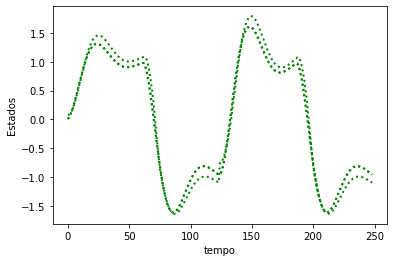

In [18]:
t_step = t[2]-t[1]
tempo_teste = 20
z0 = [0,0]
degrau = 1;
y = [];
uteste = [];
for i in range(1,int((tempo_teste/t_step).round())):
    t_teste = [(i-1)*t_step, i*t_step]
    if t_teste[1]>5 and t_teste[1]<10:
        degrau = -1;
    if t_teste[1]>=10 and t_teste[1]<15:
        degrau = 1;
    if t_teste[1]>=15 and t_teste[1]<20:
        degrau = -1;
    z = odeint(model,z0,t_teste,args = (degrau,zeta,w0,))
    z0 = z[1]
    y.append(z[1][0]);
    uteste.append(degrau)
plt.plot(y,'g:',linewidth=2,label='x2')
plt.xlabel('tempo')
plt.ylabel('Estados')
len(y)

Y1_1 = np.concatenate(([0],y))
Y1_2 = np.concatenate(([0,0],y))
Y1_1 = Y1_1[0:(len(Y1_1)-1)]
Y1_2 = Y1_2[0:(len(Y1_2)-2)]
X_teste = np.transpose(np.array([Y1_1,Y1_2,uteste]))
X_teste = torch.from_numpy(X_teste).float().to(args['device'])
#print(X_teste)
Y_net = net(X_teste)
Y_net = torch.tensor(Y_net,requires_grad=True)
#print((Y_net.cpu().detach().numpy()))
Y_net = Y_net.cpu().detach().numpy()
plt.plot(y,'g:',linewidth=2,label='y')
plt.plot(Y_net,'g:',linewidth=2,label='net')
plt.xlabel('tempo')
plt.ylabel('Estados')